# Which Kepler/K2 planets are useful for atmospheric followup?

### Assumptions

* Assume all planets have atmospheres (this is likely true for most planets)
* Assume no planets have clouds or hazes (this is unlikely)
* Assume a circular orbit (this is largely true)
* Assume HST WFC3 for followup instrument (this is reasonable)
* Assume 1 second exposure time with a scan rate of 0.15s (this could be improved for each target)
* Assume HST WFC3 has no saturation limit. (This could be acheived with scanning)
* Assume one observation is taken (this is an underestimate)
* Assume 50 pixels of the detector are illuminated for the scan (this is reasonable)
* Assume 5 scale heights of atmsophere (this is an approximation)
* Assume atmosphere is purely hyrdogen (this is likely to be wrong for most small planets)
* Assume atmosphere is entirely opaque in the WFC3 bandpass (this is an overestimate)
* Assume starspot free (this is unlikely)
* Where masses are unknown, assume mass-radius relation from Weiss 2014 (this is an approximation)
* Assume 2MASS photometry is correct (this is reasonable)
* Assume planets have no reflection, all light us absorbed

All told, this will provide an overestimate of the signal or the 'best case' scenario.

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.constants import G, m_p, k_B
%matplotlib inline
plt.style.use('ggplot')

Define small planets as 3 earth radii

In [98]:
small = 3*u.earthRad

Get the planet catalog from nexsci

In [103]:
NEXSCI_API = 'http://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI'
df = pd.read_csv(NEXSCI_API + '?table=planets&select=pl_hostname,pl_letter,pl_disc,ra,dec,pl_trandep,pl_tranflag,pl_orbsmax,pl_radj,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_eqt,pl_orbper,pl_k2flag,pl_kepflag,pl_facility,st_rad,st_teff,st_optmag,st_j,st_h', comment='#')
df.to_csv('planets.csv')

Only use the transiting planets, calculate the equillibrium temperature and transit depth as these can be nans in nexsci for some reason. 

In [104]:
#We should only do this when there are nan values
df = df[df.pl_tranflag==1].reset_index(drop=True)

nan = ~np.isfinite(df.pl_eqt)
sep = np.asarray(df.pl_orbsmax)*u.AU
rstar = (np.asarray(df.st_rad)*u.solRad).to(u.AU)
temp = np.asarray(df.st_teff)*u.K
df.loc[nan, ['pl_eqt']] = (temp[nan]*np.sqrt(rstar[nan]/(2*sep[nan])))

nan = ~np.isfinite(df.pl_trandep)
df.loc[nan,['pl_trandep']] = ((np.asarray(df.pl_radj[nan])*u.jupiterRad).to(u.solRad)/(np.asarray(df.st_rad[nan])*u.solRad))**2

Use the mass/radius relation from Weiss 2014 for planets 1.5-4 earth radii to fill in any blank masses and ones with large errors

In [105]:
nan = ~np.isfinite(df.pl_bmassj)
higherrs = df.pl_bmassjerr1/df.pl_bmassj > 0.1
low = (np.asarray(df.pl_radj)*u.jupiterRad).to(u.earthRad)  > 1.5*u.earthRad
high = (np.asarray(df.pl_radj)*u.jupiterRad).to(u.earthRad)  < 4.*u.earthRad
recalculate = np.all([low,high, np.any([nan, higherrs], axis=0)], axis=0)

rade = (np.asarray(df.loc[recalculate,'pl_radj'])*u.jupiterRad).to(u.earthRad).value
df.loc[recalculate, 'pl_bmassj'] = (((2.69* rade)**0.93)*u.earthMass).to(u.jupiterMass).value

/Users/ch/K2/repos/astropy/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in greater
  *arrays, **kwargs)
/Users/ch/K2/repos/astropy/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in less
  *arrays, **kwargs)


Assume a fully hydrogen atmosphere that has 5 scale heights and is completely opaque in the WFC3 bandpass

In [106]:
mu = 2
g = G * (np.asarray(df.pl_bmassj)*u.jupiterMass)/(np.asarray(df.pl_radj)*u.jupiterRad)**2
g = g.to(u.m/u.second**2)
H = ((k_B*np.asarray(df.pl_eqt)*u.K)/(mu * m_p*g)).to(u.km)

Change in transit depth due to atmosphere

In [107]:
delta = ((H*5) + ((np.asarray(df.pl_radj)*u.jupiterRad).to(u.km)))**2/((np.asarray(df.st_rad)*u.solRad).to(u.km))**2
delta = delta.value - np.asarray(df.pl_trandep)

df['delta'] = delta

In [108]:
#One second scan and a 50 pixel spectrum
exptime = 1
scansize = 50

star_fl = (5.5/0.15)*10.**(-0.4*(df.st_h-15))
#star_fl[star_fl>33000] = 33000
fl = df.delta*star_fl
fl *= scansize * exptime


df['snr'] = fl**0.5


k2 = df[(df.pl_k2flag==1)&(df.pl_facility=='K2')].reset_index(drop=True)
kepler = df[(df.pl_kepflag==1)&(df.pl_facility=='Kepler')].reset_index(drop=True)

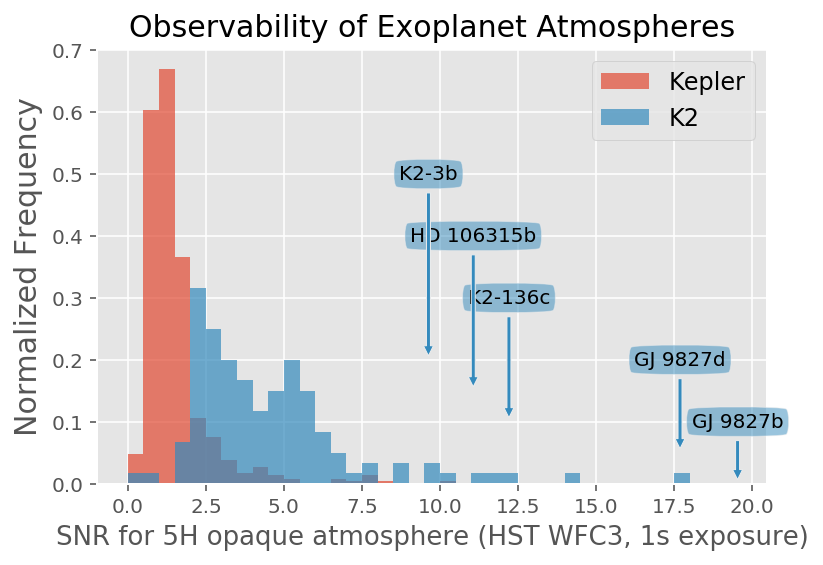

In [114]:
fig, ax = plt.subplots()
fl = kepler.snr
h=plt.hist((fl[np.isfinite(fl)]), np.arange(0,20,0.5), normed=True, alpha=0.7, label='Kepler')

fl = k2.snr
plt.hist((fl[np.isfinite(fl)]), h[1], normed=True, alpha=0.7, label='K2')

plt.xlabel('SNR for 5H opaque atmosphere (HST WFC3, 1s exposure)', fontsize=13)
plt.ylabel('Normalized Frequency', fontsize=15)
plt.title('Observability of Exoplanet Atmospheres', fontsize=15)
plt.legend(fontsize=12)
plt.savefig('charts/K2observability.png', dpi=300, bbox_inches='tight')

#Annotations
ok = (np.asarray(k2.pl_radj)*u.jupiterRad).to(u.earthRad) < small
i=0
df1 = k2[ok].sort_values('snr', ascending=False)
for i, n, l, x, y  in zip(range(len(df)), df1.pl_hostname, df1.pl_letter, df1.snr, df1.pl_orbper):
    ann = ax.annotate("{}{}".format(n, l),
                      xy=(x, 0.+i*0.05), xycoords='data',
                      xytext=(x, 0.1+i*0.1), textcoords='data',
                      size=10, va="center", ha="center",
                      bbox=dict(boxstyle="round4", fc="C1", alpha=0.5),
                      arrowprops=dict(arrowstyle="simple",
                                      connectionstyle="arc3, rad=-{}".format(0),
                                      fc="C1"), 
                      )
    i+=1
    if i>=5:
        break
        
plt.savefig('charts/K2observability_annotated.png', dpi=300, bbox_inches='tight')

/Users/ch/K2/repos/astropy/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in less
  *arrays, **kwargs)


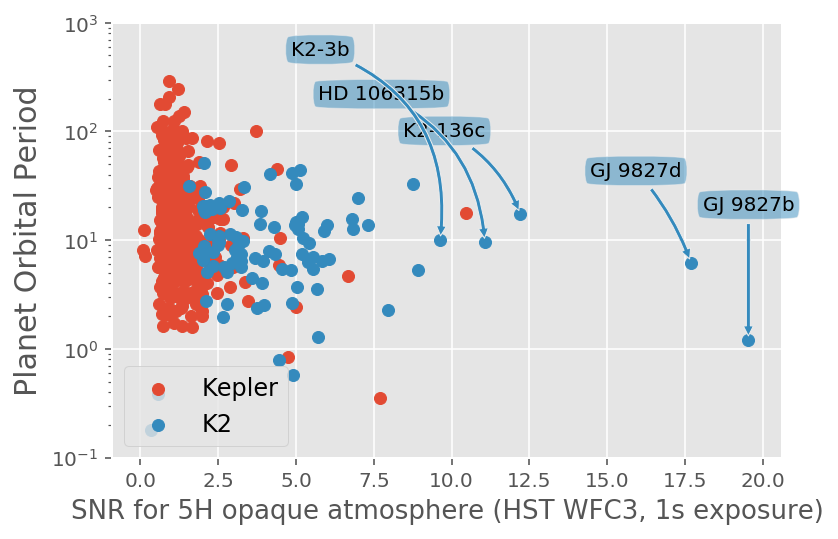

In [110]:
fig, ax = plt.subplots()
ok = (np.asarray(kepler.pl_radj)*u.jupiterRad).to(u.earthRad) < small
plt.scatter((kepler[ok].snr),kepler[ok].pl_orbper, label='Kepler')

ok = (np.asarray(k2.pl_radj)*u.jupiterRad).to(u.earthRad) < small
plt.scatter((k2[ok].snr),k2[ok].pl_orbper, label='K2')
        
plt.ylabel('Planet Orbital Period', fontsize=15)
plt.ylim(1e-1, 1e3)
plt.xlabel('SNR for 5H opaque atmosphere (HST WFC3, 1s exposure)', fontsize=13)
plt.yscale('log')
plt.legend(fontsize=12, loc='lower left')

#Annotations
i=0
df1 = k2[ok].sort_values('snr', ascending=False)
for i, n, l, x, y  in zip(range(len(df)), df1.pl_hostname, df1.pl_letter, df1.snr, df1.pl_orbper):
    ann = ax.annotate("{}{}".format(n, l),
                      xy=(x, y), xycoords='data',
                      xytext=(x*(1-(i*0.1)), y+(10+(np.exp(i)*10))), textcoords='data',
                      size=10, va="center", ha="center",
                      bbox=dict(boxstyle="round4", fc="C1", alpha=0.5),
                      arrowprops=dict(arrowstyle="simple",
                                      connectionstyle="arc3, rad=-{}".format(0.1*i),
                                      fc="C1"), 
                      )
    i+=1
    if i>=5:
        break


In [111]:
both =kepler.append(k2).reset_index(drop=True)
ok = (np.asarray(both.pl_radj)*u.jupiterRad).to(u.earthRad) < small
top = both[ok][['pl_hostname','pl_letter','pl_eqt','pl_radj','pl_bmassj','pl_orbper','delta','snr','pl_facility','pl_disc']].sort_values('snr', ascending=False)[0:20].reset_index(drop=True)

/Users/ch/K2/repos/astropy/astropy/units/quantity.py:641: RuntimeWarning: invalid value encountered in less
  *arrays, **kwargs)


In [112]:
top

,pl_hostname,pl_letter,pl_eqt,pl_radj,pl_bmassj,pl_orbper,delta,snr,pl_facility,pl_disc
0,GJ 9827,b,1044.000000,0.156,0.013279,1.208957,0.000186,19.532582,K2,2017
1,GJ 9827,d,605.000000,0.187,0.015718,6.201410,0.000153,17.688722,K2,2017
2,K2-136,c,425.000000,0.260,0.021355,17.307137,0.000203,12.208278,K2,2017
3,HD 106315,b,1146.000000,0.214,0.017818,9.553850,0.000102,11.065263,K2,2017
4,Kepler-410 A,b,1003.760808,0.253,0.020820,17.833648,0.000113,10.463358,Kepler,2013
5,K2-3,b,463.000000,0.194,0.016264,10.054490,0.000168,9.629656,K2,2015
6,K2-36,c,793.000000,0.250,0.020590,5.340590,0.000285,8.903861,K2,2016
7,K2-18,b,235.000000,0.212,0.017663,32.939630,0.000189,8.755998,K2,2015
8,K2-28,b,568.000000,0.207,0.017275,2.260455,0.000887,7.941551,K2,2016
9,Kepler-78,b,2250.000000,0.105,0.006000,0.355000,0.000240,7.699073,Kepler,2013
